In [1]:
import DataGenerator as dg
import Globals
import HelperFunctions as helpers
import HeatmapClass

from keras import layers
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import os

Using TensorFlow backend.


In [2]:
# set plt parameters
plt.rcParams['figure.figsize'] = 18, 27

# load annotation files
label_root = "../data/maritime_dataset_25/labels/"

path = "training_labels_animals.json"
with open(os.path.join(label_root, path) , 'r') as f:
    train_labels_animals = json.load(f)
    
path = "test_labels.json"
with open(os.path.join(label_root, path), 'r') as f:
    test_labels = json.load(f)
    
path = "training_labels_no_animals.json"
with open(os.path.join(label_root, path), 'r') as f:
    train_labels_no_animals = json.load(f)

# image path
#data_root = "G:/Universität/UniBremen/S emester4/Data/maritime_dataset/"#training_data_animals/"
data_root = "../data/maritime_dataset_25/"

imageShape = helpers.shapeOfFilename(os.path.join(data_root,"training_data_animals/0.jpg"))
print(f"Image format {imageShape}.")

# check if interpolate works
#helpers.showInterpolate()

Image format (736, 1088, 3).


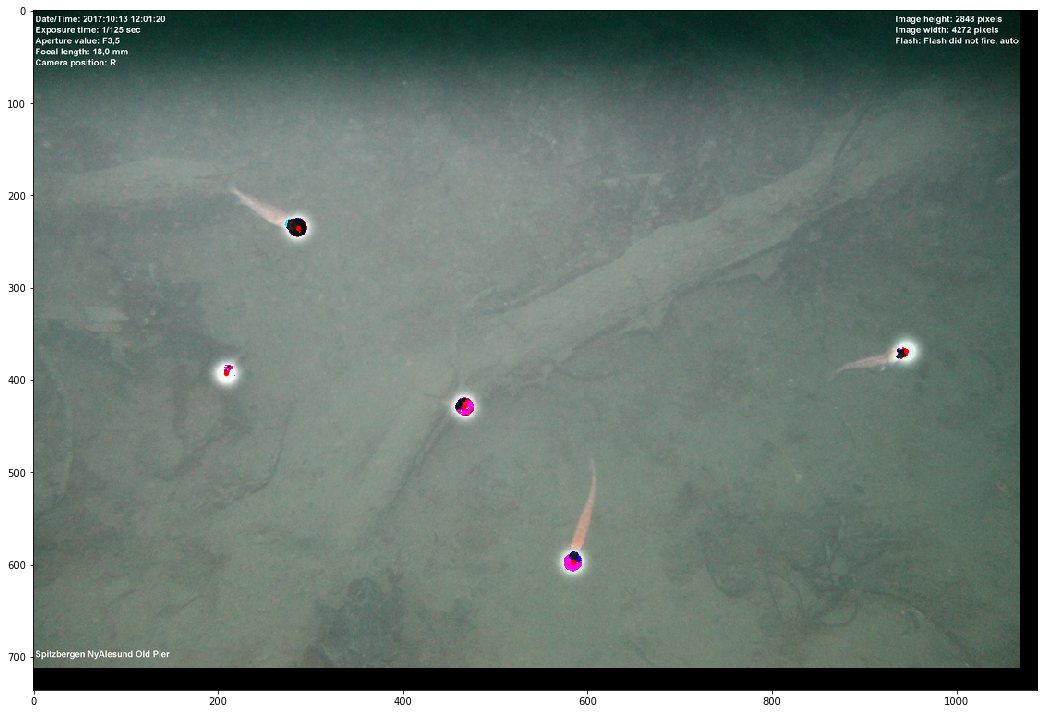

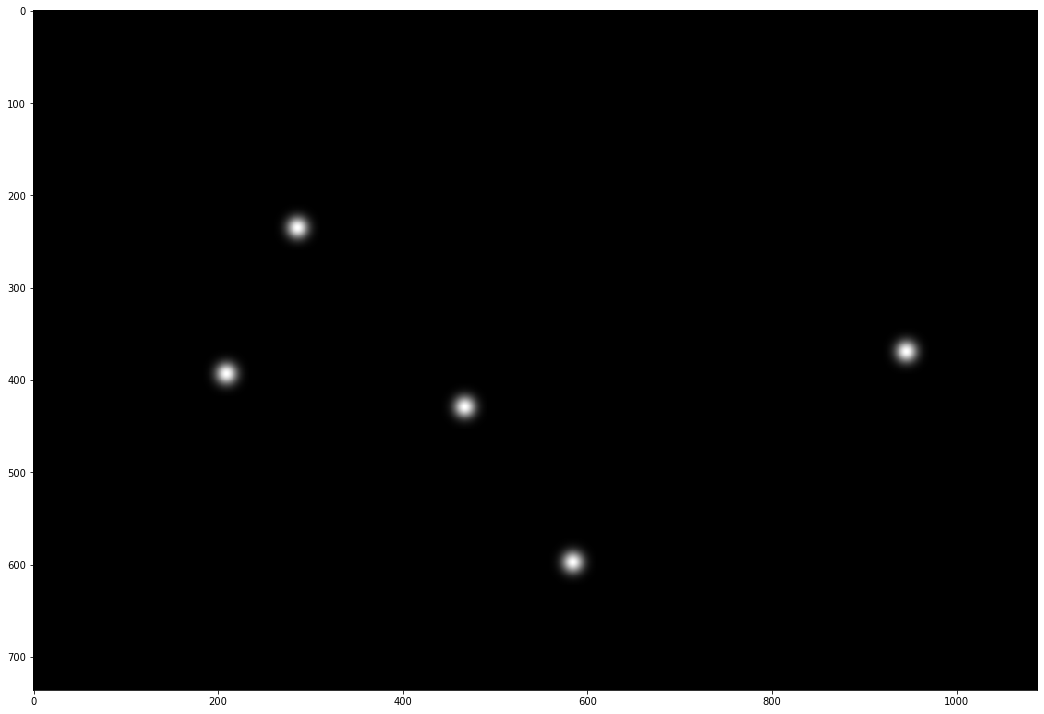

In [4]:
# show first training image with annotations (all animal groups)
entry = train_labels_animals[0]

hm = HeatmapClass.Heatmap(entry, resolution='low', group=1, bodyPart='front')
hm.showImageWithHeatmap(exagerate=1)

plt.imshow(hm.hm[:,:,0], cmap='gray')

False

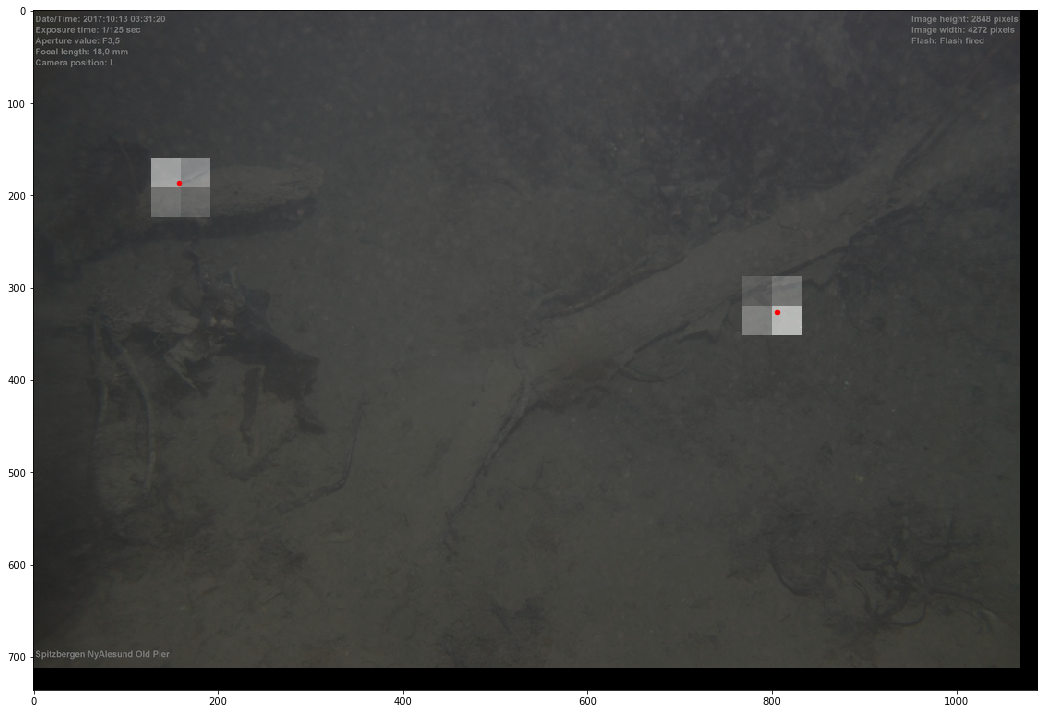

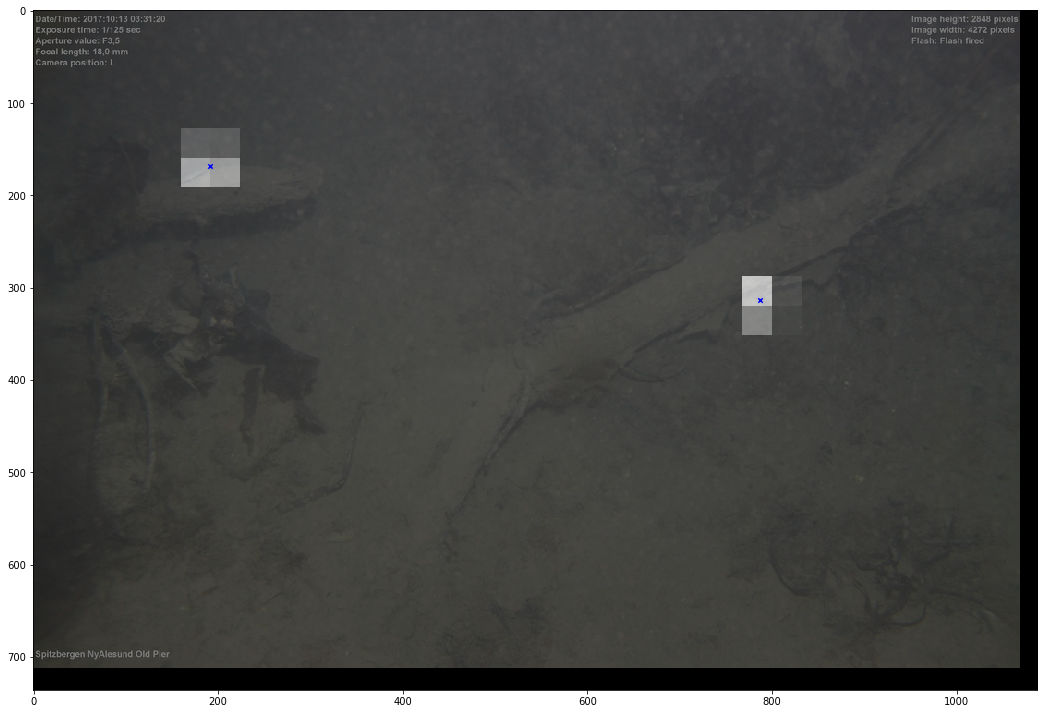

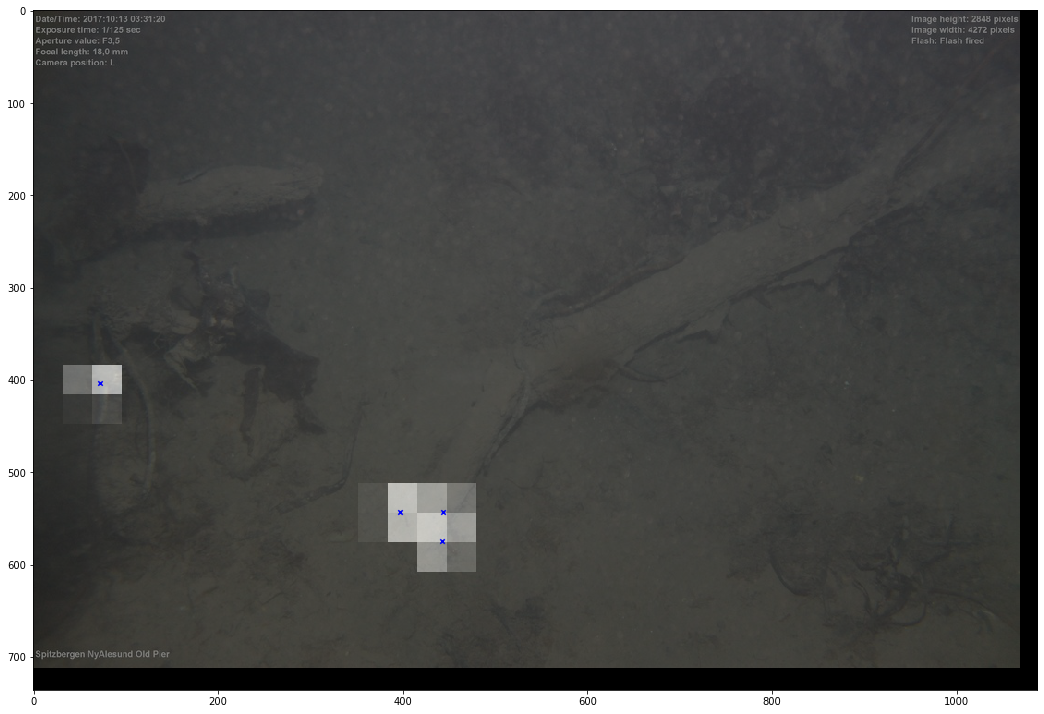

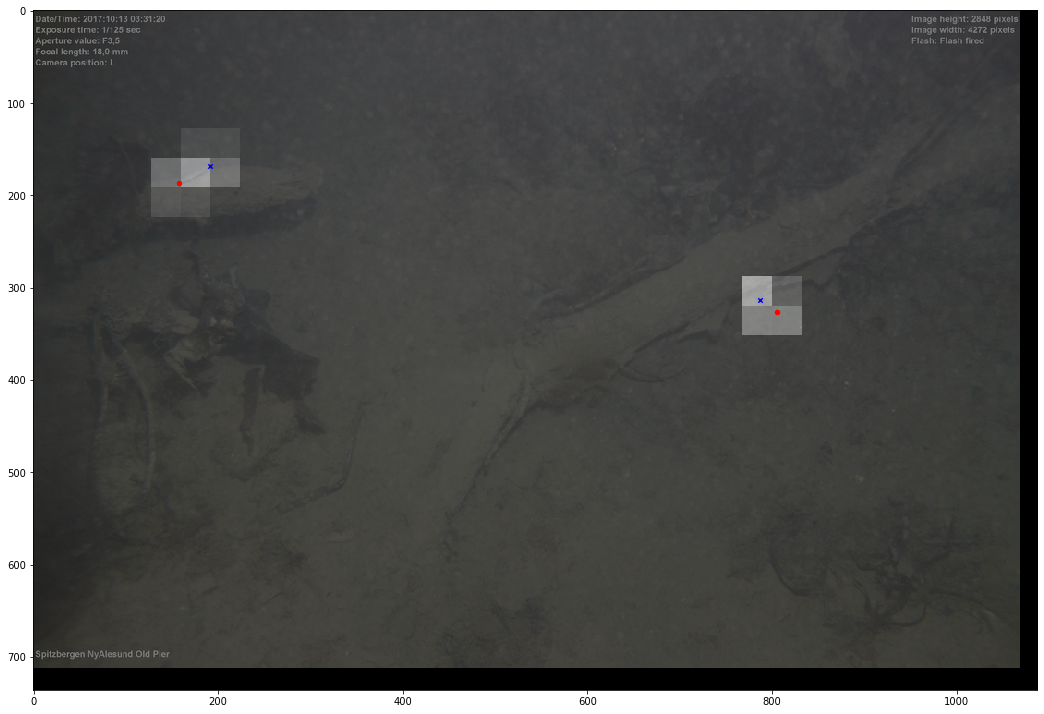

In [5]:
# test low resolution heatmap
n = 1
hm_L = HeatmapClass.Heatmap(train_labels_animals[n], group=1, bodyPart='front', resolution='low') 
hm_L.showImageWithHeatmap()
hm_L.showImageWithHeatmap(filename=None, group=1, bodyPart="back")
hm_L.showImageWithHeatmap(filename=None, group=2, bodyPart="back")
hm_L.showImageWithHeatmap(filename=None, group=1, bodyPart="both")

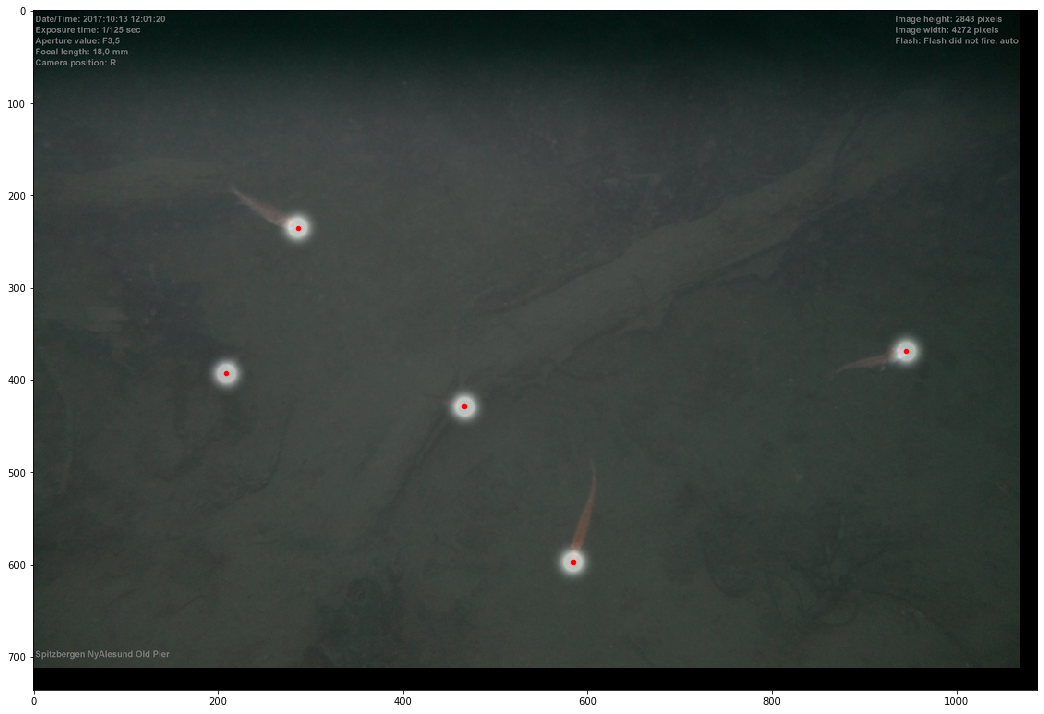

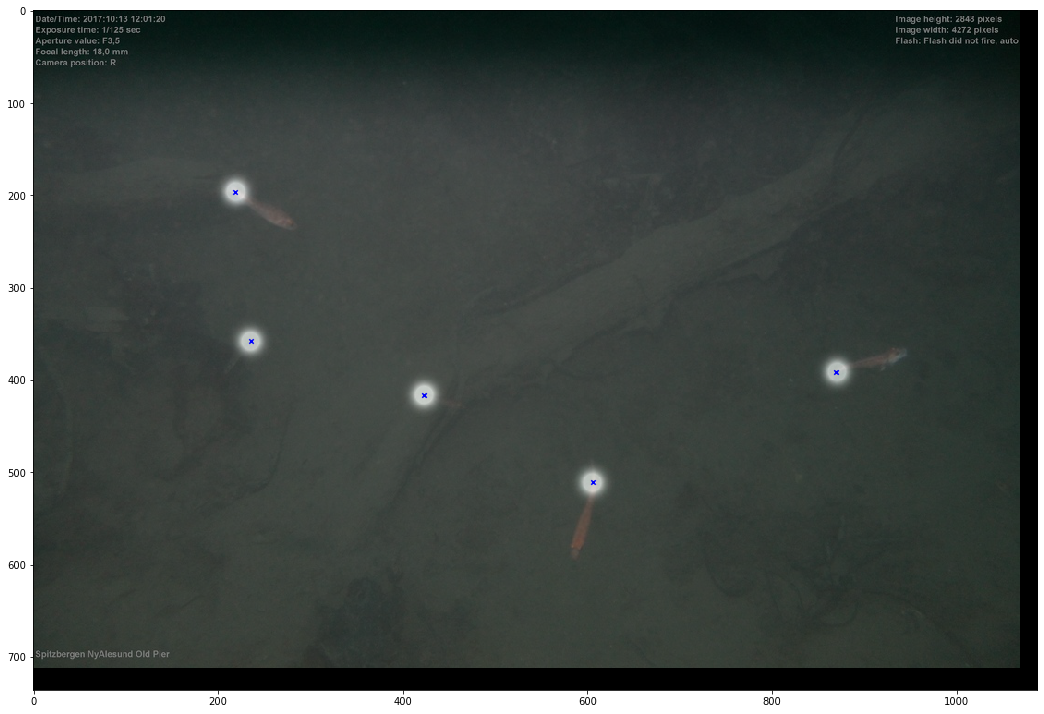

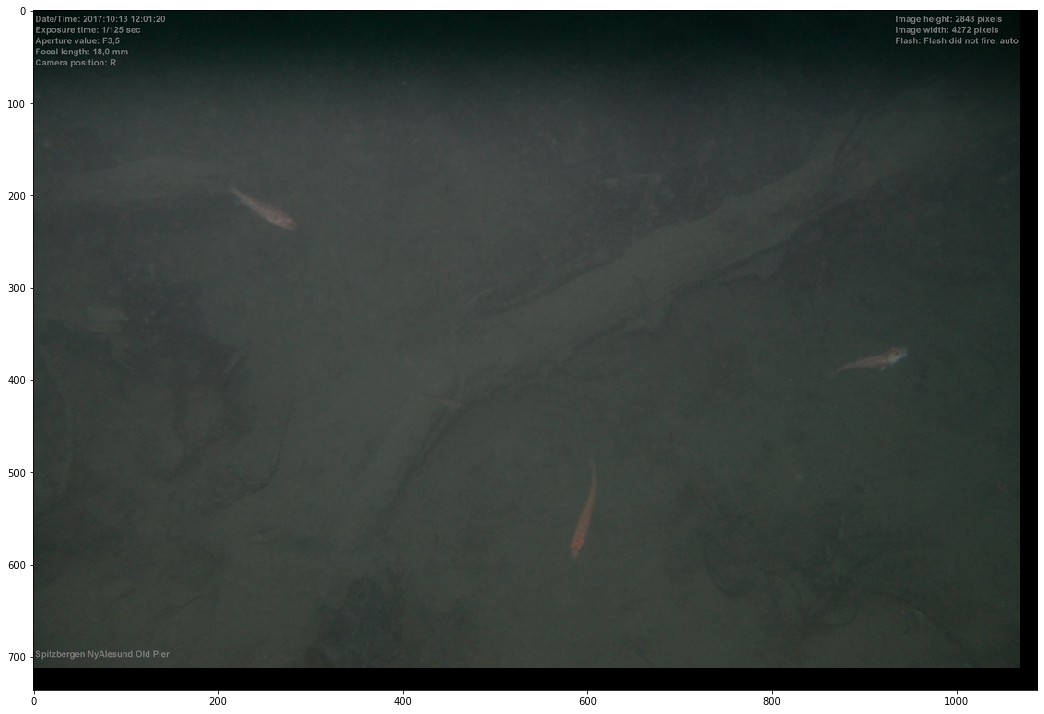

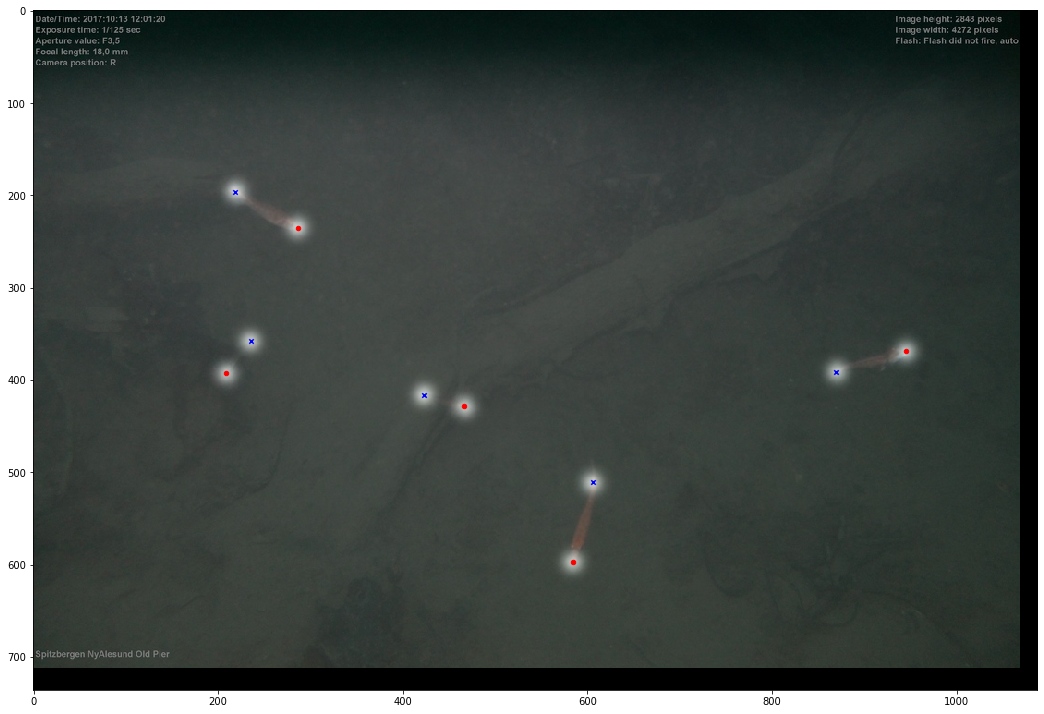

In [6]:
# test high resolution heatmap
n = 0
hm_H = HeatmapClass.Heatmap(train_labels_animals[n], group=1, bodyPart='front', resolution='high') 
hm_H.showImageWithHeatmap()
hm_H.showImageWithHeatmap(filename=None, group=1, bodyPart="back")
hm_H.showImageWithHeatmap(filename=None, group=2, bodyPart="back")
hm_H.showImageWithHeatmap(filename=None, group=1, bodyPart="both")

In [7]:
# test data generators
# low resolution
trainGenL = dg.DataGenerator (dataset=train_labels_animals, 
                              no_animal_dataset=train_labels_no_animals,
                              no_animal_ratio=Globals.no_animal_ratio,
                              prepareEntry=dg.prepareEntryLowResHeatmap,
                              batch_size=Globals.batch_size)

testGenL = dg.DataGenerator (dataset=test_labels, 
                              prepareEntry=dg.prepareEntryLowResHeatmap,
                              batch_size=Globals.batch_size)

# high resolution
trainGenH = dg.DataGenerator (dataset=train_labels_animals, 
                              no_animal_dataset=train_labels_no_animals,
                              no_animal_ratio=Globals.no_animal_ratio,
                              prepareEntry=dg.prepareEntryHighResHeatmap, 
                              batch_size=Globals.batch_size)

testGenH = dg.DataGenerator (dataset=test_labels, 
                             prepareEntry=dg.prepareEntryHighResHeatmap,
                             batch_size=Globals.batch_size)

In [8]:
dg.showEntryOfGenerator (trainGenL,0)
dg.showEntryOfGenerator (trainGenH,0)

X has shape (4, 736, 1088, 3), type float64 and range [-1.000..1.000]
y has shape (4, 23, 34, 1), type float32 and range [0.000..1.000] and entropy [0.0027407..0.0138703]
X has shape (4, 736, 1088, 3), type float64 and range [-1.000..1.000]
y has shape (4, 736, 1088, 1), type float32 and range [0.000..1.000] and entropy [0.0010828..0.0060838]


In [9]:
# Now construct the low-res net and store it into the variable model
# Loading of MobileNet.V2 will give a warning "`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default."
# That's correct.
# Proceed as described in abv-uebung-6.pdf and discuss the architecture.
# Inspect the architecture with model.summary() to make sure, that the number of trainable weights
# is compatible to the amount of data we have.
#
# For reference you can access the MobileNet.V2 source code at
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py

def ourBlock (x, basename, channels=8):
    """Our own block of computation layers used several times in the network. It is similar to
    the block used in MobileNet.V2 but simplified. x is the layer to attach the block to,
    basename the name of this block, which will be extended by layer names. channel is the
    number of channels in the output (internally a multiple of that). The final layer is returned."""
    # First reduce to the defined no of channels to avoid having too many weights
    x = layers.Conv2D (channels, 1, padding='same', name = basename+"_bottleneck_conv")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_bottleneck_BN')(x)
    x = layers.ReLU(6., name=basename+'_bottleneck_relu')(x)

    x = layers.Conv2D (4*channels, 1, padding='same', name = basename+"_conv")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_BN')(x)
    x = layers.ReLU(6., name=basename+'_relu')(x)

    x = layers.DepthwiseConv2D(kernel_size=3, activation=None, use_bias=False, padding='same', name=basename+'-DW')(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_DW_BN')(x)
    x = layers.ReLU(6., name=basename+'_DW_relu')(x)
    x = layers.Conv2D (channels, 1, padding='same', name = basename+"_project")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_project_BN')(x)
    
    return x

alpha = 1.0
input = keras.layers.Input(shape=imageShape)
backbone = keras.applications.mobilenet_v2.MobileNetV2(alpha=alpha, input_tensor=input, include_top=False, weights='imagenet', pooling=None)
for l in backbone.layers:
    l.trainable = False
# We attach to the layer with 320 channels because with a 1280 channel input this conv would have too many weights
x = backbone.get_layer("block_16_project_BN").output

# Computational block á la MobileNet.V2
x = ourBlock (x, "block_17")
   
# Final output layer with sigmoid, because heatmap is within 0..1
x = layers.Conv2D (1, 1, padding='same', activation='sigmoid', name = "block_18_conv_output")(x)

modelL = keras.Model(inputs=input, outputs=x)
modelL.compile(loss='mse', optimizer='adam', metrics=['mae'])
modelL.summary()

C:\Users\yjenn\Anaconda3\envs\fish-env\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 736, 1088, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 737, 1089, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 368, 544, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 368, 544, 32) 128         Conv1[0][0]                      
_____________________________

In [10]:
# Train the low-res-net
#model.load_weights ("strawberry-L.h5"), #load a previous checkpoint
#for ctr in range(10):
modelL.fit_generator(generator=trainGenL, epochs=1, validation_data=testGenL)
#modelL.save_weights(f"fish-L-{ctr}.h5") # saves weights (e.g. a checkpoint) locally
  
    #files.download('fish-L.h5') # download weights from e.g. google-colab to local machine

Epoch 1/1
362/363 [============================>.] - ETA: 1s - loss: 0.1084 - mae: 0.2290

ResourceExhaustedError:  OOM when allocating tensor with shape[384,369,545] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node block_1_pad/Pad (defined at C:\Users\yjenn\Anaconda3\envs\fish-env\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_14024]

Function call stack:
keras_scratch_graph


In [ ]:
# Use this to visualize results
# It shows the input image (background), the predicted heatmap (white "fog" in foreground)
# and the ground-truth (blue crosses)
testIdx = random.randint(0,len(testGenL))
testBatch = testGenL[testIdx]
gtBatch = testGenL.get_ground_truth (testIdx)
yHats = modelL.predict (testBatch[0])
for i in range(0,len(yHats)):
    helpers.showImageWithHeatmap (testBatch[0][i], yHats[i], gtBatch[i], filename=f"result-L-{i}.png") 

In [9]:
# MUSTERLÖSUNG
x = modelL.get_layer("block_17_project_BN").output # low-res model before last conv-sigmoid layer
x = layers.UpSampling2D(interpolation='bilinear', name='block_19_upto16')(x)
# Concatenate with the layer before the expansion that is followed by conv and downsample
x = layers.Concatenate(name="block_19_concat")([x,modelL.get_layer("block_12_add").output])
x = ourBlock (x, 'block_19')

x = layers.UpSampling2D(interpolation='bilinear', name='block_20_upto8')(x)
x = layers.Concatenate(name="block_20_concat")([x,modelL.get_layer("block_5_add").output])
x = ourBlock (x, 'block_20')

x = layers.UpSampling2D(interpolation='bilinear', name='block_21_upto4')(x)
x = layers.Concatenate(name="block_21_concat")([x,modelL.get_layer("block_2_add").output])
x = ourBlock (x, 'block_21')

x = layers.UpSampling2D(interpolation='bilinear', name='block_22_upto2')(x)
x = layers.Concatenate(name="block_22_concat")([x,modelL.get_layer("expanded_conv_project_BN").output])
x = ourBlock (x, 'block_22')

x = layers.UpSampling2D(interpolation='bilinear', name='block_23_upto1')(x)
#x = layers.Concatenate(name="block_23_concat")([x, input])
#x = layers.Conv2D (8, 3, padding='same', name = "block_23_conv")(x)
#x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name='block_23_BN')(x)
#x = layers.ReLU(6., name='block_23_relu')(x)
x = ourBlock (x, 'block_23', channels=4)

x = layers.Conv2D (1, 1, padding='same', activation='sigmoid', name = "block_23_conv_output")(x)


modelH = keras.Model(inputs=input, outputs=x)
modelH.compile(loss='mse', optimizer='adam', metrics=['mae'])
modelH.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 736, 1088, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 737, 1089, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 368, 544, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 368, 544, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [11]:
# Train the high-res-net
#model.load_weights ("strawberry-H.h5"), #load a previous checkpoint
#while True:
modelH.fit_generator(generator=trainGenH, epochs=1, validation_data=testGenH)
#modelH.save_weights("strawberry-H.h5") # saves weights (e.g. a checkpoint) locally
  #files.download('strawberry-H.h5') # download weights from e.g. google-colab to local machine

Epoch 1/1


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[4,4,736,1088] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_2/Adam/gradients/zeros_13}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_1/mae/Identity/_3219]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[4,4,736,1088] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_2/Adam/gradients/zeros_13}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
# Use this to visualize results
# It shows the input image (background), the predicted heatmap (white "fog" in foreground)
# and the ground-truth (blue crosses)
testIdx = random.randint(0,len(testGenH))
testBatch = testGenH[testIdx]
gtBatch = testGenH.get_ground_truth (testIdx)
yHats = modelH.predict (testBatch[0])
for i in range(0,len(yHats)):
    helpers.showImageWithHeatmap (testBatch[0][i], yHats[i], gtBatch[i], filename=f"result-H-{i}.png") 